No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-38-a4c1adbb3d2c>:163: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csxv=np.zeros((circle.Np,levels,levels),dtype=np.complex)


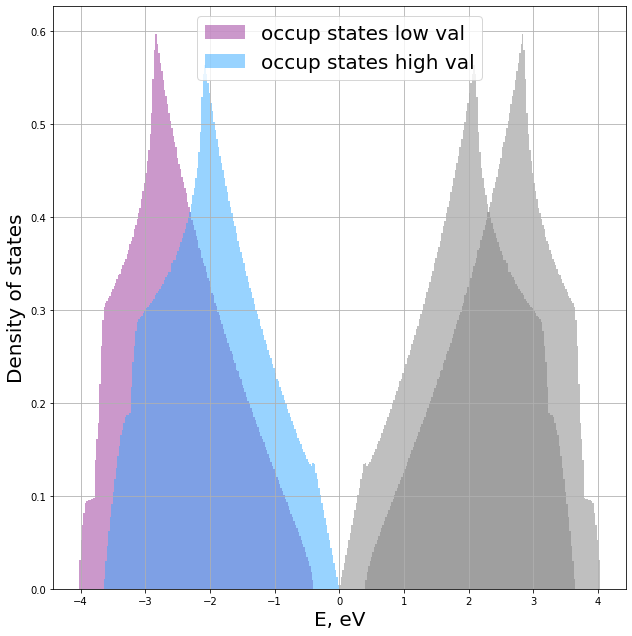

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import mdirac as md

### bilayer graphene constants
gamma = 3 # hopping parameter in graphene
t = 2*np.pi*np.sqrt(3)/2*gamma # effective multiplier before dimensionless k*sigma in hamiltonian
t0 = 0.4 # eV
deg = 4 # spin+valley degeneracy
###

### grid settings. scale 
kstep0 = 0.0004
scale=0.4
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(2/kstep0)
kmesh = md.mesh.Parallelogram(N,cell)
circle = kmesh.get_MBZ(scale=scale)
###

### system settings
def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise
path = 'out/bi_gr/gamma'+str(gamma)+'kstep0'+str(kstep0)+'t0'+str(t0)+'nn'
mkdir_p(path)
###

### eigensystem writing
timelog = open(path+"/timelog.txt", "w")
startTime = time.time()

def MonolayerHamiltonianPrecise(kx,ky,g):
    """
    input: dimensionless kx,ky in units of 2pi/a in BZ, gamma approx 3 eV
    output: hamiltonian of monolayer graphene hamiltonian expanded around K point (bottom one for certainty)
    ??corrected x->y final x axis (in which k is counted) goes from K to Gamma point (up)
    ??corrected y->x final y axis pi/2 clockwise from x axis (to the right)
    """
    #Hab = g*(1+np.exp(-1.j*np.sqrt(3)*np.pi*kx)*2*np.cos(np.pi*ky+2*np.pi/3))
    arg1 = -1.j*np.sqrt(3)*np.pi*kx
    arg2 = np.pi*ky-2/3*np.pi
    Hab = g*(1+np.exp(arg1)*2*np.cos(arg2))
    Hba = np.conj(Hab)
    ham = np.array([[0,Hba],[Hab,0]])
    return ham

def BilayerHamiltonian(kx,ky,gamma,t0):
    """
    bilayer graphene hamiltonian based on monolayer linear hamiltonian
    interlayer coupling accounts only AB with hopping parameter t0 approx 0.4 eV
    """
    ham_mono1 = MonolayerHamiltonianPrecise(kx,ky,gamma)
    ham_mono2 = MonolayerHamiltonianPrecise(kx,ky,gamma)
    inter_scat = np.array([[0,t0],[t0,0]])
    ham = np.block([[ham_mono1, inter_scat], [inter_scat, ham_mono2]])
    return ham

size = 4
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1.j],[1.j,0]])

E=np.zeros((circle.Np,size),dtype=np.float64)
U=np.zeros((circle.Np,size,size),dtype=np.complex128)
for i,pi in enumerate(circle.p):
    ham = BilayerHamiltonian(pi[0],pi[1],gamma,t0)
    E[i],U[i]=np.linalg.eigh(ham)

executionTime = (time.time() - startTime)
timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')

### dispersion curves plotting

Nst = 2/3
stepsGK = int(Nst/kstep0)
stepsKM = int(1/2*Nst/kstep0)
stepsMG = int(np.sqrt(3)/2*Nst/kstep0)

kGKx = 0
kGKy = -1*kstep0
kKMx = -0.5*np.sqrt(3)*kstep0
kKMy = 0.5*kstep0
kMGx = 0.5*kstep0
kMGy = 0.5*np.sqrt(3)*kstep0

kx = 0
ky = Nst

AllK = stepsGK+stepsKM+stepsMG
disp = np.zeros((AllK,4),float)

for i in np.arange(stepsGK):
    kx += kGKx
    ky += kGKy
    ham = BilayerHamiltonian(kx,ky,gamma,t0)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)

for i in np.arange(stepsGK,stepsGK+stepsKM):
    kx += kKMx
    ky += kKMy
    ham = BilayerHamiltonian(kx,ky,gamma,t0)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)

for i in np.arange(stepsGK+stepsKM,stepsGK+stepsKM+stepsMG):
    kx += kMGx
    ky += kMGy
    ham = BilayerHamiltonian(kx,ky,gamma,t0)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)


fig, ax = plt.subplots(figsize=(9,9))
list=['low cond', 'high cond']
for j in range(2,4):
    plt.plot(np.arange(AllK), disp[:,j], linestyle="-", linewidth=5,label='bilayer graphene '+list[j-2])
    
ax.set_ylabel('E, eV', fontsize=20)
plt.ylim(-0.1,10.5)
ax.grid()
ax.legend(loc='upper right', fontsize=20)
fig.tight_layout()
plt.xticks(np.array([0,stepsGK,stepsGK+stepsKM,stepsGK+stepsKM+stepsMG]),[r'$\Gamma$',"K","M",r'$\Gamma$'], fontsize=20)
plt.tight_layout()
plt.savefig(path+'/GKMG.png',dpi=180)
plt.close()


### DoS plotting
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('E, eV', fontsize=20)
ax.set_ylabel('Density of states', fontsize=20)
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
plt.hist(E[:,0],bins='auto',density=True,color='#993399',label='occup states low val',alpha=0.5)
plt.hist(E[:,1],bins='auto',density=True,color='#33A8FF',label='occup states high val',alpha=0.5)
plt.hist(E[:,2],bins='auto',density=True,color='#808080',alpha=0.5)
plt.hist(E[:,3],bins='auto',density=True,color='#808080',alpha=0.5)

plt.legend(fontsize=20)
plt.savefig(path+'/dos.png',dpi=180)

### spectra writing parameters
#### omega is in units of eV 
bound = 3.5
scaleomega = 3.5/1000
omega=np.linspace(1.e-5,bound,1000) 
eta=1.5e-2
factorsigma=-deg*kmesh.vcell*gamma**2*3/1.j 
levels=2
edge_v = levels-1
edge_c = levels
csxv=np.zeros((circle.Np,levels,levels),dtype=np.complex)
dE=np.zeros((circle.Np,levels,levels),dtype=np.float64)
sigma0=np.zeros((omega.shape[0],levels,levels),dtype=np.complex128)
###

### calculation of spectra
keys0 = np.identity(levels)
sx=np.array([[0,1],[1,0]])
Sx=np.kron(keys0,sx)

for ind_v in np.arange(edge_v,edge_v-levels,-1):
    for ind_c in np.arange(edge_c,edge_c+levels,1):
        i = edge_v-ind_v
        j = ind_c - edge_c
        csxv[:,i,j] = md.cov_matrix_elements(Sx,U,ind_c,ind_v)
        dE[:,i,j] = E[:,ind_c]-E[:,ind_v]
        sigma0[:,i,j]=md.get_sigma_xx(factorsigma,omega+1.j*eta,dE[:,i,j],csxv[:,i,j])

alph = 1/137
lambd = 1240/omega # eV -> nm
d = 2*0.335 # graphene thickness, nm
eps = 1+1/2*alph*np.sum(sigma0,axis=(1,2))*lambd/d*1.j
###

### plotting results
def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots()
    ax.plot(scaleomega*omegas,
            np.real(np.sum(sigma0[left_cut:right_cut],axis=(1,2))),
            c='y',label='graphene bilayer bernal',lw=8)
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
    ax.set_ylim([0.8,3.1])
    ax.legend(loc='upper right')
    fig.tight_layout()
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(realsigmapath,dpi=180)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    refr = np.sqrt(eps)[left_cut:right_cut]
    fig,ax=plt.subplots(dpi=180)
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n bilayer bernal')
    ax.plot(scaleomega*omegas,refr.imag,c='g',label='k bilayer bernal')
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,np.max(refr.real)+1])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.legend(loc='upper right')
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
    np.savetxt(path+'/optconsts.txt',conststofile)
    plt.close()

SigmaPlotter(100,1000,scaleomega,omega,sigma0)
OptConstsPlotter(100,1000,scaleomega,omega,eps)
###